<a href="https://colab.research.google.com/github/Tanvi1505/TinyLlama/blob/main/Fine_Tuning_TinyLlama_to_Generate_Stories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Fine-tuning TinyLlama to generate stories


In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not curr

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [ ]:
import wandb

In [ ]:
wandb.init(
    project="fine-tuning-llama-hw4q2",  # Name of the project
    name="tiny-llama-fine-tuning",     # Name of this specific run
    tags=["fine-tuning", "llama", "hw4"],  # Optional: Tags for easier filterin
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# The instruction dataset to use

dataset_name = "FareedKhan/1k_stories_100_genre"

# Fine-tuned model name
new_model = "llama-2-7b-miniguanaco"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 3

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

Training Parameters for Efficient Resource Usage
Batch Size (per_device_train_batch_size):
Using a batch size of 4 for training and evaluation balances memory usage and training speed, ensuring the model fits within the available GPU memory.

4-Bit Quantization:
The model is loaded with 4-bit quantization to ensure it fits within the limited GPU memory of Colab.

LoRA Fine-Tuning:
LoRA fine-tuning is used instead of full fine-tuning, which only updates a small fraction of the model's parameters, reducing both memory and computational requirements.

Gradient Checkpointing:
Enabled to minimize memory usage during backpropagation by saving only essential intermediate states.

Efficient Optimizer (paged_adamw_32bit):
The use of this optimizer ensures low memory usage while maintaining computational efficiency.

In [ ]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name)

This dataset contains 1000 stories spanning 100 different genres. Each story is represented in a tabular format using a dataframe.

Average Length of Words
Title: 6 words
Story: 960 words

This is a small dataset so taking complete dataset for training

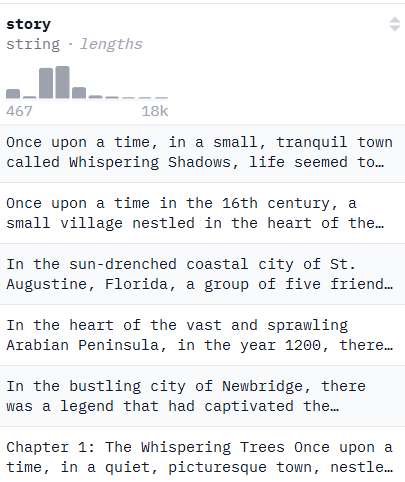

In [ ]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training


Some weights of LlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.17.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.3.self_attn.rotary_emb.inv_freq', 'model.layers.12.self_attn.ro

In [ ]:
prompt = "There once was a girl named Terry"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


<s>[INST] There once was a girl named Terry [/INST]
She was a little girl with big dreams [INST]
But her parents couldn't afford [INST]
So they sent her to live with an aunt [INST]
Terry was happy in her new home [INST]
But she missed her family and her friends [INST]
So she decided to go back to her hometown [INST]
And find a way to make ends meet [INST]
Terry started working at a diner [INST]
And saved every penny she earned [INST]
She saved enough to buy a car [INST]
And she drove to her hometown [INST]
Terry arrived at her parents' house [INST]
And they were overjoyed to see her [INST]
They hugged her tightly and told her [INST]
That they were proud of her and


In [ ]:
prompt = "Once upon a time, in the Newyork"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Once upon a time, in the Newyork [/INST] of the 1920s, there was a young woman named [NAME] who lived with her parents in a small apartment on [INST] Street. She was a bright and curious child, always eager to learn and explore the world around her. One day, while wandering through the city streets, she stumbled upon a strange and mysterious object. It was a small, glowing orb, with a strange, otherworldly energy emanating from it.

As she approached the orb, she felt a strange sensation in her body, as if she were being drawn towards it. Suddenly, she felt a powerful force emanating from the orb, and she knew that she had to find out more about it.

She spent the next few days exploring the orb, learning about its properties and how it worked. She discovered that it was


In [ ]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    #report_to="tensorboard"
    report_to=["wandb"],  # Add W&B here
    run_name="tiny-llama-fine-tuning"  # Optional: Set a custom run name
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of LlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.17.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

In [ ]:
# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
25,1.550200
50,1.582600
75,1.466300
100,1.475400
125,1.406700
150,1.476000
175,1.382100
200,1.459700
225,1.410100
250,1.441300


In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model, this is where you can test out the model inference
#Try out a different prompt!
prompt = "There once was a girl named Terry"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


<s>[INST] There once was a girl named Terry [/INST] who loved to play with her toys. One day, she found a big box of toys in her room. She opened the box and saw a lot of different toys. She was so excited!

Terry decided to play with the toys. She started by playing with the dolls. She put them in a special place in her room. She also played with the cars and the trains. She had so much fun!

But then, Terry's mom came home. She saw the toys and was worried. She asked Terry what she was playing with. Terry told her about the toys in the box. She said they were special and she loved them.

Her mom was happy to hear that. She said she would take the toys away from Terry. She said she would make sure they were safe. Terry was sad to hear this. She said she


In [ ]:
prompt = "Once upon a time, in the Newyork"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Once upon a time, in the Newyork [/INST] city, there was a little girl named Lily. She was very curious about the world around her. One day, she decided to explore the city. She went to the park and saw a big tree. She wanted to climb up the tree, but she was too small.

[INST] "Lily, can you climb up the tree?" asked her mom.

[LILY] "No, I can't. I'm too small."

[INST] "Well, you can try to climb up the branches. Maybe you can find a branch that is bigger than you."

[LILY] "I don't know how to find a branch that is bigger than me."

[INST] "You can try to look around. Maybe you can find a branch that is bigger than the one you are on right


wandb project link

[link text](https://api.wandb.ai/links/poojareddykolimi-indiana-university/twcb8784)



Before fine-tuning, the generated text consisted of individual sentences that were meaningful on their own but lacked a logical connection or flow, making it difficult to perceive a unified story. The sentences often appeared disjointed, with abrupt transitions and inconsistencies in tense, which detracted from the overall narrative quality. This behavior is indicative of a general-purpose language model that has not been specifically trained for storytelling or maintaining narrative coherence over extended sequences.

After fine-tuning, the model demonstrated a significant improvement in generating text that resembled a narrative. The sentences were no longer standalone but interconnected, following a logical progression that mimicked the structure of a story. Tense usage became consistent throughout the generated text, enhancing the readability and immersion of the output. The fine-tuned model's ability to maintain narrative continuity is a direct result of the fine-tuning process, which exposed the model to storytelling-specific datasets, helping it learn the intricacies of crafting coherent and engaging narratives.